# Predicting Taxa with Machine Learning

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor

from micropyome.utils import log
from micropyome.taxa import regression

log.silence()  # Decrease the verbosity. Comment the line out to ease debugging.

## Averill et al Data

### Bacterial Taxa Predictions

This section predicts the relative abundance of bacteria in the dataset
generated by Averill et al.

In [3]:
DATASET_PATH = "../data/averill/bacteria/"

In [21]:
X = {}  # Input data of the model (i.e. environmental features).
Y = {}  # Output data of the model (i.e. relative abundances).
for level in regression.TAXONOMIC_LEVELS:
    x = pd.read_csv(f"{DATASET_PATH}{level}/15_variables.csv")
    if level == 'fg':
        y = pd.read_csv(f"{DATASET_PATH}{level}/observed.csv")
    else:
        y = pd.read_csv(f"{DATASET_PATH}{level}/y_11groupTaxo.csv")

    x = x.drop(x.columns[0], axis=1)  # Drop the ID of the sample.
    # Scale features to remove the mean and make the variance unitary.
    scaler = StandardScaler()
    x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

    y = y.drop(y.columns[0], axis=1)  # Drop the ID of the sample.

    X[level] = x
    Y[level] = y

In [5]:
# Print the first few lines of the environmental features for inspection.
X["fg"].head()

,latitude,longitude,depth_max,forest,map,map_sd,mat,mat_sd,map_CV,mat_CV,mdr,aridity,NPP,relEM,pH
0,1.147716,0.978292,0.353059,-0.377004,-0.339015,0.036913,0.14976,0.383209,-0.42967,-1.211041,-0.956228,0.335795,0.436806,0.898665,1.459879
1,1.147716,0.978292,0.353059,-0.377004,-0.339015,-1.154817,0.14976,-1.019236,-0.42967,-1.211041,-0.956228,0.335795,0.436806,0.898665,1.478591
2,1.147716,0.978292,0.353059,-0.377004,-0.339015,0.478979,0.14976,-0.866171,-0.42967,-1.211041,-0.956228,0.335795,0.436806,0.898665,1.272760
3,1.147716,0.978292,0.353059,-0.377004,-0.339015,0.043150,0.14976,0.583066,-0.42967,-1.211041,-0.956228,0.335795,0.436806,0.898665,1.375676
4,1.147716,0.978292,0.353059,-0.377004,-0.339015,-0.590535,0.14976,0.679796,-0.42967,-1.211041,-0.956228,0.335795,0.436806,0.898665,1.450523


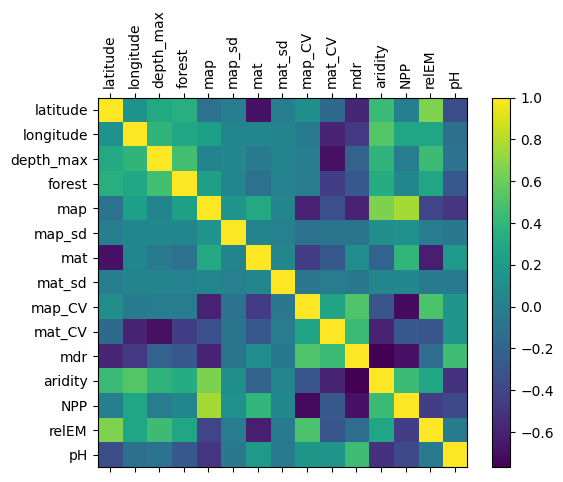

In [6]:
def view_autocorrelation(data: pd.DataFrame, name: str = None) -> None:
    """Graph the autocorrelation of variables.

    Args:
        data: Environmental features
        name: If provided, filepath of the saved image.
    """
    ex = data.copy()
    fig = plt.figure()
    ax = fig.add_subplot()
    cax = ax.matshow(ex.corr())
    fig.colorbar(cax)
    labels = ex.columns.values
    ax.set_yticks(list(range(len(labels))), labels)
    ax.set_xticks(list(range(len(labels))), labels, rotation=90)
    if name:
        plt.savefig(name)
    plt.show()


view_autocorrelation(X["fg"])

In [7]:
# Print the first few lines of the environmental features for inspection.
Y["fg"].head()

,other,assim_nitrate_reduction,assim_nitrite_reduction,cellulolytic,chitinolytic,copiotroph,denitrification,dissim_nitrate_reduction,dissim_nitrite_reduction,lignolytic,methanotroph,n_fixation,nitrification,oligotroph
0,0.893046,0.000957,0.002588,0.002595,0.002333,0.037817,0.003547,0.003358,0.005295,0.002366,0.000083,0.006273,0.000286,0.039454
1,0.889777,0.000788,0.004186,0.001942,0.002881,0.035736,0.003214,0.004851,0.004819,0.001714,0.000155,0.006312,0.000527,0.043100
2,0.848038,0.002428,0.006368,0.006620,0.003244,0.053938,0.008511,0.013298,0.005656,0.000937,0.000637,0.013354,0.000244,0.036729
3,0.866138,0.003326,0.004454,0.002900,0.003436,0.044006,0.005105,0.008007,0.008106,0.001687,0.000110,0.013447,0.000876,0.038404
4,0.885077,0.001408,0.000693,0.003014,0.001311,0.021446,0.004757,0.004836,0.004989,0.000560,0.000360,0.008940,0.000809,0.061803


In [15]:
# Measure the performances of the regression made by Averill et al.
Y_PRED = {}
Y2 = {}  # The same data as Y, but without the unpredicted data.
for level in regression.TAXONOMIC_LEVELS:
    y = pd.read_csv(f"{DATASET_PATH}{level}/observed.csv")
    y_pred = pd.read_csv(f"{DATASET_PATH}{level}/predicted.csv")
    y_samples = y[y.columns[0]].to_list()
    for sample in y_pred[y_pred.columns[0]]:
        if not sample in y_samples:
            y_pred.drop(sample)
    # Remove IDs
    y_pred = y_pred.drop(y_pred.columns[0], axis=1)
    y = y.drop(y.columns[0], axis=1)
    Y2[level] = y
    Y_PRED[level] = y_pred

averill_raw_results = []
for level in regression.TAXONOMIC_LEVELS:
    r = regression.r2_score_by_column(Y_PRED[level], Y2[level])
    averill_raw_results.append(np.mean(r))


THRESHOLD = 0.003
averill_filtered_results = []
for level in regression.TAXONOMIC_LEVELS:
    y, y_pred = Y2[level], Y_PRED[level]
    for column in y.columns:
        if y[column].mean() < THRESHOLD:
            y = y.drop(columns=[column])
            y_pred = y_pred.drop(columns=[column])
    r = regression.r2_score_by_column(y, y_pred)
    averill_filtered_results.append(np.mean(r))

print("Raw published results: ", averill_raw_results)
print("Published results: ", averill_filtered_results)


def graph_results(models: dict, results: dict):
    x = list(range(len(regression.TAXONOMIC_LEVELS)))

    for model in models:
        y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
        print(f"{model}: {y}")
        plt.plot(x, y, "-o", label=model)

    plt.plot(x, averill_raw_results, "-o", label="Averill, raw")
    plt.plot(x, averill_filtered_results, "-o", label="Averill, filtered")

    plt.xticks(x, regression.TAXONOMIC_LEVELS)
    plt.legend()
    plt.show()

Raw published results:  [0.40657152762402543, -0.5433697169861594, -0.5173425938870791, -0.9041966927341941, -1.6164396003593628, -4.139020863235174]
Published results:  [0.6694304599634192, 0.4939120573376682, 0.3947728965535883, 0.44519862920621506, 0.3528865773869716, 0.2349787872136751]


Create and Train Models

#### k-NN

k-10: [0.19358908495910257, 0.45803629690858927, 0.40834363832479614, 0.4258591076625988, 0.3127411345872644, 0.14048295861118368]
k-20: [0.23829236858906944, 0.44728627812005933, 0.4052137529593217, 0.41822355861591215, 0.33374938812859317, 0.1992935551545149]
k-30: [0.2441568374794718, 0.42573785901879246, 0.3802290998889918, 0.39686232532545185, 0.3226799837467185, 0.20825341186287663]


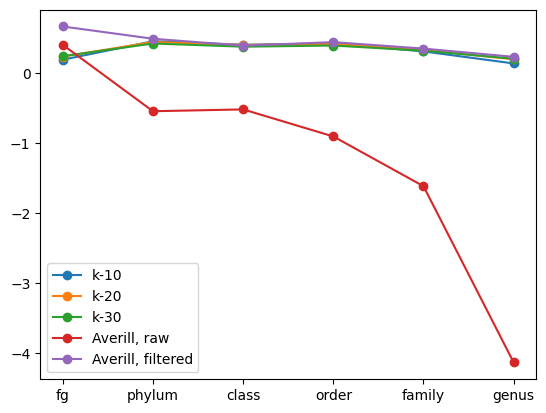

In [18]:
models = {
    "k-10": KNeighborsRegressor(10),
    "k-20": KNeighborsRegressor(20),
    "k-30": KNeighborsRegressor(30),
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)
graph_results(models, results)

k-10: [0.17262101191711557, 0.4605063224536773, 0.3950306843446269, 0.4167753800462468, 0.33191387605271266, 0.15084633693657176]
k-20: [0.21474257277306052, 0.4537994225645819, 0.39428156076650167, 0.4127897922791102, 0.34133028602187654, 0.21138133439797024]
k-10-d: [0.16247348095906317, 0.47308597779862405, 0.4057548718888618, 0.41411466656905455, 0.32042863022710977, 0.15020234943029842]
k-20-d: [0.20993502772770936, 0.4769414830175755, 0.41224961401397486, 0.4258194278035489, 0.34510286499524934, 0.2143636355235811]


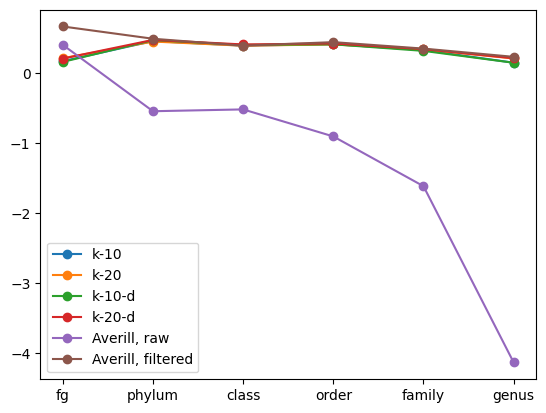

k-10: [0.18622892889420478, 0.4621598812185974, 0.40752211538130245, 0.4276576440129095, 0.29385637339344683, 0.27000581675096325]
k-20: [0.22772332312632368, 0.4517052627319453, 0.39643620731504303, 0.4251494510213452, 0.3223108211181053, 0.29652243242447274]
k-10-d: [0.18398252958070377, 0.4745390678568361, 0.4190808758787662, 0.42736836347621343, 0.29232406409874245, 0.24215891729266442]
k-20-d: [0.2265147339876065, 0.4752544360915108, 0.4197973675343835, 0.43800961966935176, 0.32662954287052565, 0.28887916214612336]


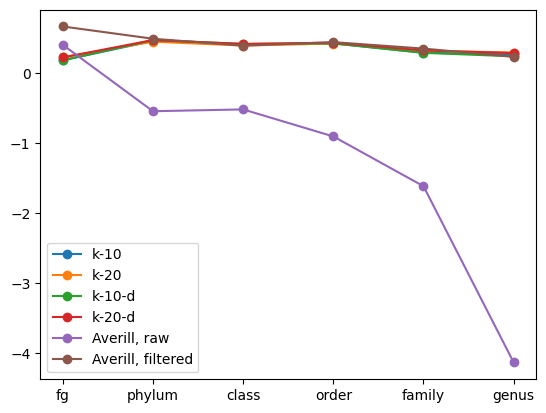

In [19]:
models = {
    "k-10": KNeighborsRegressor(10),
    "k-20": KNeighborsRegressor(20),
    "k-10-d": KNeighborsRegressor(10, weights="distance"),
    "k-20-d": KNeighborsRegressor(20, weights="distance"),
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, k_fold=5)
graph_results(models, results)
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)
graph_results(models, results)

#### Linear Models

C:\Users\vince\AppData\Local\Temp\ipykernel_4636\216985067.py:5: RuntimeWarning: invalid value encountered in log
  y = np.log(p / (1 - p))
C:\Users\vince\AppData\Local\Temp\ipykernel_4636\216985067.py:5: RuntimeWarning: invalid value encountered in log
  y = np.log(p / (1 - p))
C:\Users\vince\AppData\Local\Temp\ipykernel_4636\216985067.py:5: RuntimeWarning: invalid value encountered in log
  y = np.log(p / (1 - p))
C:\Users\vince\AppData\Local\Temp\ipykernel_4636\216985067.py:5: RuntimeWarning: invalid value encountered in log
  y = np.log(p / (1 - p))
C:\Users\vince\AppData\Local\Temp\ipykernel_4636\216985067.py:5: RuntimeWarning: invalid value encountered in log
  y = np.log(p / (1 - p))


Logit: [0.15377739595528167, 0.2234076188468798, 0.18115260741014327, 0.1591433746593774, 0.050477380735918495, -0.09868423283901848]
Linear: [0.20551705317646177, 0.35244125475553084, 0.27396442742766364, 0.3104728188572575, 0.2439172607286781, 0.16338301110601477]


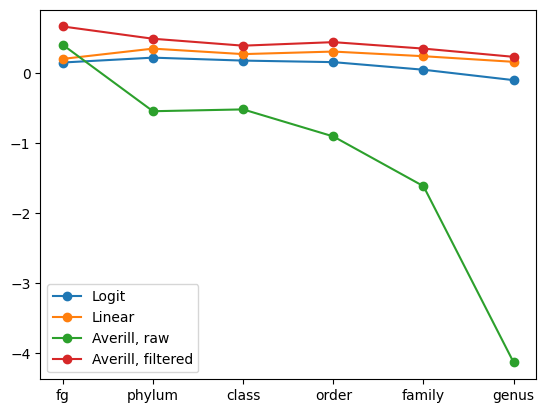

C:\Users\vince\AppData\Local\Temp\ipykernel_4636\216985067.py:5: RuntimeWarning: invalid value encountered in log
  y = np.log(p / (1 - p))
C:\Users\vince\AppData\Local\Temp\ipykernel_4636\216985067.py:5: RuntimeWarning: invalid value encountered in log
  y = np.log(p / (1 - p))
C:\Users\vince\AppData\Local\Temp\ipykernel_4636\216985067.py:5: RuntimeWarning: invalid value encountered in log
  y = np.log(p / (1 - p))
C:\Users\vince\AppData\Local\Temp\ipykernel_4636\216985067.py:5: RuntimeWarning: invalid value encountered in log
  y = np.log(p / (1 - p))
C:\Users\vince\AppData\Local\Temp\ipykernel_4636\216985067.py:5: RuntimeWarning: invalid value encountered in log
  y = np.log(p / (1 - p))


Logit: [0.18742377414019798, 0.21818513201932582, 0.16458161214473307, 0.15322089860568752, 0.053813265677962185, -0.026643830499544042]
Linear: [0.21986321772251677, 0.35231201058519573, 0.2661127446683731, 0.31175479765702163, 0.24967230956324812, 0.1672541096892996]


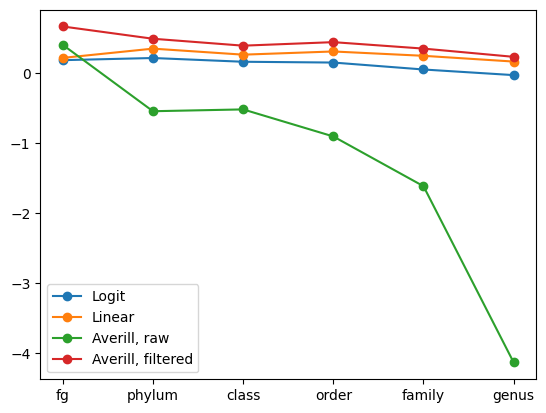

In [23]:
class LogitRegression(LinearRegression):

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        y = np.nan_to_num(y, nan=0)
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)


models = {
    "Logit": LogitRegression(),
    "Linear": LinearRegression()
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, k_fold=5)
graph_results(models, results)
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)
graph_results(models, results)

#### Decision Tree

Decision tree: [-0.46298781659982746, 0.128096090202814, 0.010237283669257451, -0.035472246934584006, -0.11288777914405881, -1.5890474410733872]


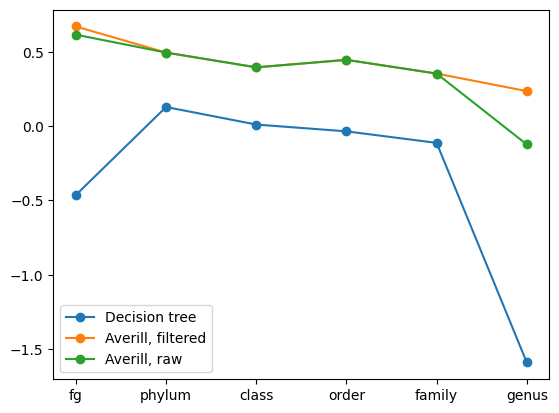

Decision tree: [-0.5335685365931881, 0.1821656831828299, 0.056304754347593765, -0.11078419014238775, -0.20296042756030416, -0.736614232879437]


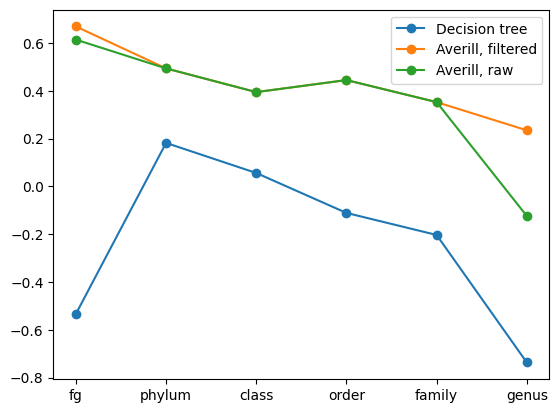

In [12]:
models = {
    "Decision tree": DecisionTreeRegressor()
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, k_fold=5)
graph_results(models, results)
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)
graph_results(models, results)

d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
115 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
34 fits failed with the following error:
Traceback (most recent call last):
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\stage\micropyome\venv\Lib\site-package

Optimized DT: [0.14198760802916519, 0.455089967749209, 0.4470806125211957, 0.4295448306542319, 0.3089053675285314, 0.1759367883076194]
Default DT: [-0.5964281751420055, 0.15050041629390706, -0.09233710917736916, -0.16350552696495316, -0.5196861397676076, -1.2758581842550867]


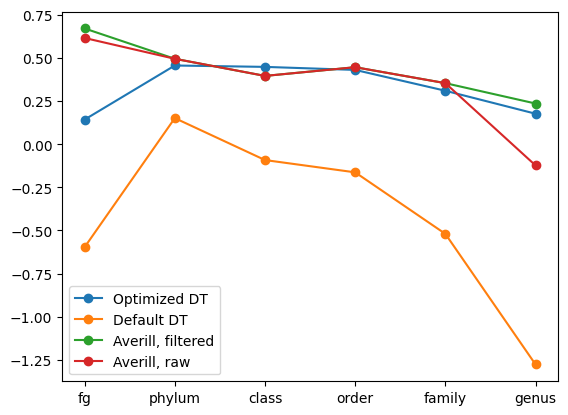

In [13]:
meta_params = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': list(range(1, 8)),
    'min_samples_leaf': list(range(1, 8)),
    'max_features': [None, 'auto', 'sqrt', 'log2', 0.5, 0.8]
}

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

custom_r2_scorer = make_scorer(
    lambda o, p: np.mean(regression.r2_score_by_column(o, p)), greater_is_better=True
)

params = {}
for level in regression.TAXONOMIC_LEVELS:
    model = DecisionTreeRegressor()
    search = RandomizedSearchCV(model, meta_params, n_iter=100, cv=5, scoring=custom_r2_scorer, n_jobs=-1, verbose=0)
    x_train, x_test, y_train, y_test = train_test_split(X[level], Y[level], test_size=0.2)
    search.fit(x_train, y_train)
    params[level] = search.best_params_

results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model = DecisionTreeRegressor(**params[level])
    r = regression.train_evaluate_models(
        {"Optimized DT": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Optimized DT"] = r["Optimized DT"]
    model = DecisionTreeRegressor()
    r = regression.train_evaluate_models(
        {"Default DT": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Default DT"] = r["Default DT"]

graph_results(["Optimized DT", "Default DT"], results)


Optimized DT: [0.12030453868245836, 0.4640888458575567, 0.421336943477994, 0.4139152810475477, 0.29303816743922806, 0.2233886834969911]


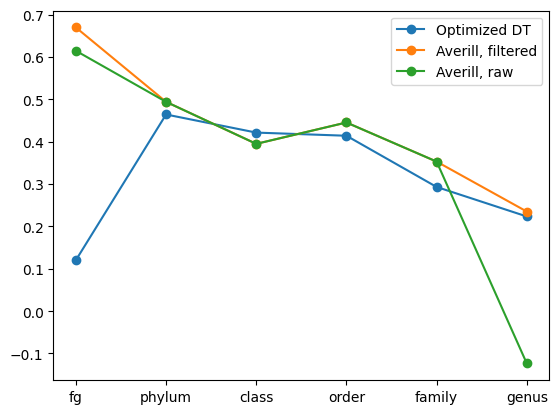

Optimized DT: [0.1802201167791238, 0.4760133089171631, 0.42187498848112026, 0.4191813684522547, 0.29325321688021144, 0.15532033807093398]


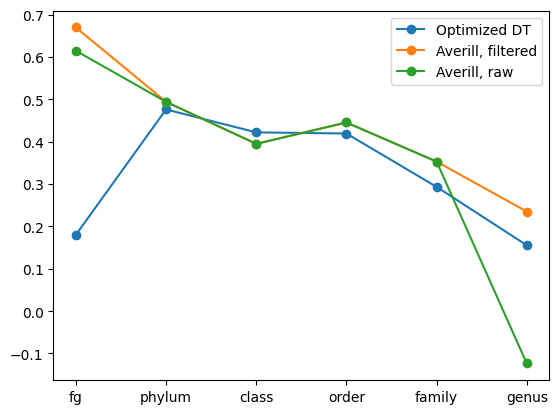

In [14]:
results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model = DecisionTreeRegressor(**params[level])
    r = regression.train_evaluate_models(
        {"Optimized DT": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Optimized DT"] = r["Optimized DT"]

graph_results(["Optimized DT"], results)


results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model = DecisionTreeRegressor(**params[level])
    r = regression.train_evaluate_models(
        {"Optimized DT": model}, X[level], Y[level], threshold=0.003, k_fold=5
    )
    results[level]["Optimized DT"] = r["Optimized DT"]

graph_results(["Optimized DT"], results)

#### Random Forest

In [15]:
meta_params = {
    'n_estimators': list(range(80, 120)),  # Close to default of 100
    'max_depth': [None, 5, 10, 20, 30],  # Default is None
    'min_samples_split': list(range(1, 8)),  # Default is 2
    'min_samples_leaf': list(range(1, 5)),  # Default is 1
    'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.8]  # Default is 'auto'
}

params = {}
for level in regression.TAXONOMIC_LEVELS:
    model = RandomForestRegressor()
    search = RandomizedSearchCV(model, meta_params, n_iter=100, cv=5, scoring=custom_r2_scorer, n_jobs=-1, verbose=0)
    x_train, x_test, y_train, y_test = train_test_split(X[level], Y[level], test_size=0.2)
    search.fit(x_train, y_train)
    params[level] = search.best_params_

results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model = RandomForestRegressor(**params[level])
    r = regression.train_evaluate_models(
        {"Optimized RF": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Optimized RF"] = r["Optimized RF"]
    model = RandomForestRegressor()
    r = regression.train_evaluate_models(
        {"Default RF": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Default RF"] = r["Default RF"]

graph_results(["Optimized RF", "Default RF"], results)

d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
155 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
34 fits failed with the following error:
Traceback (most recent call last):
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\stage\micropyome\venv\Lib\site-package

KeyboardInterrupt: 

Optimized RF: [0.2664496203358812, 0.5646992337712727, 0.5039324283654976, 0.4991146590437161, 0.3900442346349692, 0.31338591677745065]
Default RF: [0.21114586892500817, 0.5217155111498576, 0.4521860310804363, 0.4558346706853144, 0.3192435495052973, -0.25722601876245665]


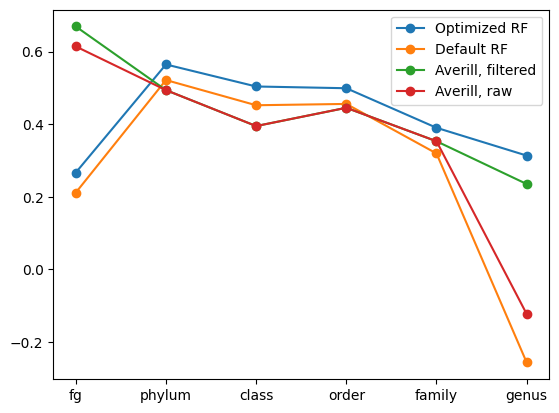

In [ ]:
results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model = RandomForestRegressor(**params[level])
    r = regression.train_evaluate_models(
        {"Optimized RF": model}, X[level], Y[level], threshold=0.003, k_fold=5
    )
    results[level]["Optimized RF"] = r["Optimized RF"]
    model = RandomForestRegressor()
    r = regression.train_evaluate_models(
        {"Default RF": model}, X[level], Y[level], threshold=0.003, k_fold=5
    )
    results[level]["Default RF"] = r["Default RF"]

graph_results(["Optimized RF", "Default RF"], results)

#### Gradient Boosting

In [ ]:
meta_params = {
    'estimator__n_estimators': list(range(80, 120)),  # Close to default of 100
    'estimator__learning_rate': [0.05, 0.1, 0.15, 0.2],  # Default is 0.1
    'estimator__max_depth': [3, 4, 5, 6, 7, 8],  # Default is 3
    'estimator__min_samples_split': list(range(1, 10)),  # Default is 2
    'estimator__min_samples_leaf': list(range(1, 6)),  # Default is 1
    'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.8],  # Default is None
    'estimator__subsample': [0.6, 0.7, 0.8, 0.9, 1.0]  # Default is 1.0
}

params = {}
for level in regression.TAXONOMIC_LEVELS:
    model =  MultiOutputRegressor(GradientBoostingRegressor())
    search = RandomizedSearchCV(model, meta_params, n_iter=100, cv=5, scoring=custom_r2_scorer, n_jobs=-1, verbose=0)
    x_train, x_test, y_train, y_test = train_test_split(X[level], Y[level], test_size=0.2)
    search.fit(x_train, y_train)
    params[level] = search.best_params_

d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
50 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\multioutput.py", line 272, in fit
    self.estimators_ = Pa

{'fg': {'estimator__subsample': 0.9, 'estimator__n_estimators': 82, 'estimator__min_samples_split': 4, 'estimator__min_samples_leaf': 3, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 3, 'estimator__learning_rate': 0.05}, 'phylum': {'estimator__subsample': 0.6, 'estimator__n_estimators': 94, 'estimator__min_samples_split': 6, 'estimator__min_samples_leaf': 3, 'estimator__max_features': 'log2', 'estimator__max_depth': 5, 'estimator__learning_rate': 0.05}, 'class': {'estimator__subsample': 1.0, 'estimator__n_estimators': 90, 'estimator__min_samples_split': 9, 'estimator__min_samples_leaf': 4, 'estimator__max_features': 'log2', 'estimator__max_depth': 4, 'estimator__learning_rate': 0.05}, 'order': {'estimator__subsample': 0.7, 'estimator__n_estimators': 88, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 5, 'estimator__max_features': 'log2', 'estimator__max_depth': 4, 'estimator__learning_rate': 0.05}, 'family': {'estimator__subsample': 0.9, 'estimator__n_est

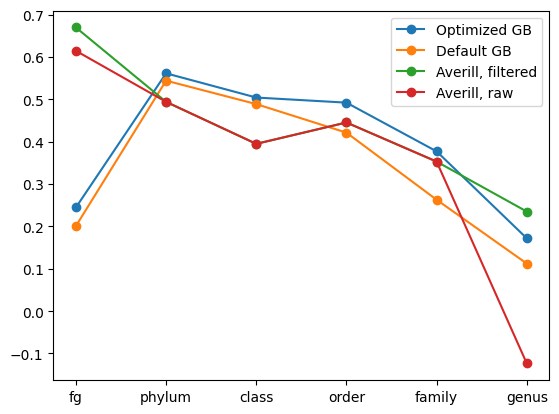

In [ ]:
renamed_params = {}
for level in params:
    renamed_params[level] = {}
    for param in params[level]:
        new_param = param.split("__")[-1]
        renamed_params[level][new_param] = params[level][param]
print(renamed_params)

results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model =  MultiOutputRegressor(GradientBoostingRegressor(**renamed_params[level]))
    r = regression.train_evaluate_models(
        {"Optimized GB": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Optimized GB"] = r["Optimized GB"]
    model = MultiOutputRegressor(GradientBoostingRegressor())
    r = regression.train_evaluate_models(
        {"Default GB": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Default GB"] = r["Default GB"]

graph_results(["Optimized GB", "Default GB"], results)

Optimized GB: [0.26304067606452364, 0.5561290806330941, 0.4957066859221461, 0.4943522504835414, 0.37716897982205205, 0.29074990644375925]
Default GB: [0.21760059262795234, 0.535021489193567, 0.4765137304386598, 0.4702855559640162, 0.21840143396121398, 0.08511212278350293]


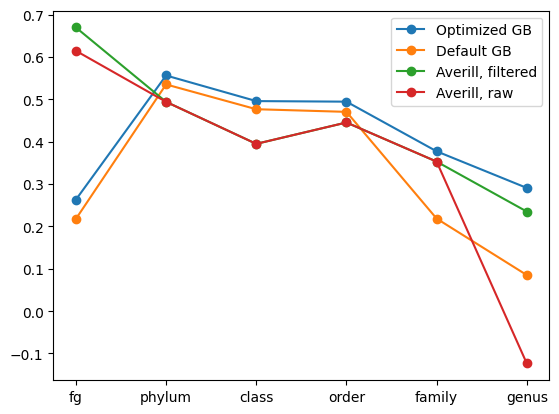

In [ ]:
results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model =  MultiOutputRegressor(GradientBoostingRegressor(**renamed_params[level]))
    r = regression.train_evaluate_models(
        {"Optimized GB": model}, X[level], Y[level], threshold=0.003, k_fold=5
    )
    results[level]["Optimized GB"] = r["Optimized GB"]
    model = MultiOutputRegressor(GradientBoostingRegressor())
    r = regression.train_evaluate_models(
        {"Default GB": model}, X[level], Y[level], threshold=0.003, k_fold=5
    )
    results[level]["Default GB"] = r["Default GB"]

graph_results(["Optimized GB", "Default GB"], results)

### Fungal Taxa Predictions

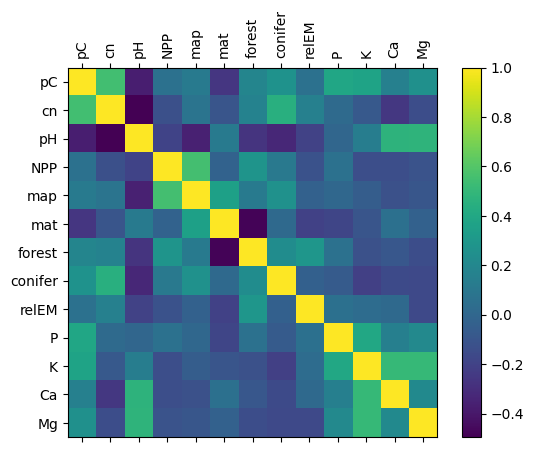

In [28]:
DATASET_PATH = "../data/averill/fungi/"
X = {}
Y = {}

for level in regression.TAXONOMIC_LEVELS:
    x = pd.read_csv(f"{DATASET_PATH}{level}/13_variables.csv")
    y = pd.read_csv(f"{DATASET_PATH}{level}/observed.csv")

    x = x.drop(x.columns[0], axis=1) # Drop the ID of the sample.
    # Scale features to remove the mean and make the variance unitary.
    scaler = StandardScaler()
    x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

    y = y.drop(y.columns[0], axis=1) # Drop the ID of the sample.
    if level == "phylum":
        y = y.drop(columns=["other"])  # Special case to avoid poor predictions.

    X[level] = x
    Y[level] = y


view_autocorrelation(X["fg"], "averill_fungi.eps")

In [ ]:
Y2 = {}  # Averill et al. results.
for level in regression.TAXONOMIC_LEVELS:
    y2 = pd.read_csv(f"{DATASET_PATH}{level}/predicted.csv")
    y2 = y2.drop(y2.columns[0], axis=1)
    if level == "phylum":
        y2 = y2.drop(columns=["other"])
    y2 = regression.normalize_categories(y2)
    Y2[level] = y2


raw_published_results = []
for level in regression.TAXONOMIC_LEVELS:
    r = regression.r2_score_by_column(Y[level], Y2[level])
    raw_published_results.append(np.mean(r))

published_results = []
for level in regression.TAXONOMIC_LEVELS:
    y, y2 = Y[level], Y2[level]
    threshold = 0.012
    for column in y.columns:
        if y[column].mean() < threshold:
            y = y.drop(columns=[column])
            y2 = y2.drop(columns=[column])
    r = regression.r2_score_by_column(y, y2)
    published_results.append(np.mean(r))

print("Raw published results: ", raw_published_results)
print("Published results: ", published_results)


def graph_results(models: dict, results: dict):
    x = list(range(len(regression.TAXONOMIC_LEVELS)))

    for model in models:
        y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
        print(f"{model}: {y}")
        plt.plot(x, y, "-o", label=model)

    plt.plot(x, published_results, "-o", label="Averill, filtered")
    plt.plot(x, raw_published_results, "-o", label="Averill, raw")

    plt.xticks(x, regression.TAXONOMIC_LEVELS)
    plt.legend()
    plt.show()


from sklearn.metrics import make_scorer

custom_r2_scorer = make_scorer(
    lambda o, p: np.mean(regression.r2_score_by_column(o, p)), greater_is_better=True
)

#### Logit

2024-07-10T17:12:56.541716 > INFO Evaluating 2 models with 5 splits.
2024-07-10T17:12:56.543717 > INFO Level: fg
2024-07-10T17:12:56.545226 > INFO K-fold split: 0
2024-07-10T17:12:56.548754 > INFO Beginning the evaluation of 2 models.
2024-07-10T17:12:56.571416 > INFO K-fold split: 1
2024-07-10T17:12:56.575034 > INFO Beginning the evaluation of 2 models.
2024-07-10T17:12:56.589617 > INFO K-fold split: 2
2024-07-10T17:12:56.593122 > INFO Beginning the evaluation of 2 models.
2024-07-10T17:12:56.612228 > INFO K-fold split: 3
2024-07-10T17:12:56.615738 > INFO Beginning the evaluation of 2 models.
2024-07-10T17:12:56.630972 > INFO K-fold split: 4
2024-07-10T17:12:56.635488 > INFO Beginning the evaluation of 2 models.
2024-07-10T17:12:56.649066 > INFO Level: phylum
2024-07-10T17:12:56.651587 > INFO K-fold split: 0
2024-07-10T17:12:56.655197 > INFO Beginning the evaluation of 2 models.
2024-07-10T17:12:56.672063 > INFO K-fold split: 1
2024-07-10T17:12:56.676732 > INFO Beginning the evaluatio

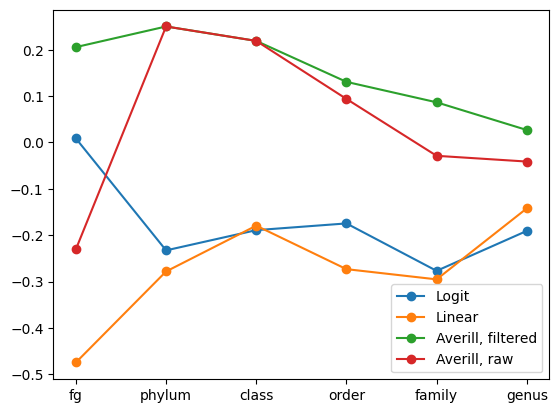

2024-07-10T17:12:57.434137 > INFO Evaluating 2 models with 5 splits.
2024-07-10T17:12:57.435138 > INFO Level: fg
2024-07-10T17:12:57.437167 > INFO K-fold split: 0
2024-07-10T17:12:57.440166 > INFO Beginning the evaluation of 2 models.
2024-07-10T17:12:57.446904 > INFO Dropped 2 columns.
2024-07-10T17:12:57.457515 > INFO Dropped 2 columns.
2024-07-10T17:12:57.465027 > INFO K-fold split: 1
2024-07-10T17:12:57.469953 > INFO Beginning the evaluation of 2 models.
2024-07-10T17:12:57.478580 > INFO Dropped 1 columns.
2024-07-10T17:12:57.488505 > INFO Dropped 1 columns.
2024-07-10T17:12:57.495063 > INFO K-fold split: 2
2024-07-10T17:12:57.499725 > INFO Beginning the evaluation of 2 models.
2024-07-10T17:12:57.509311 > INFO Dropped 1 columns.
2024-07-10T17:12:57.520248 > INFO Dropped 1 columns.
2024-07-10T17:12:57.526421 > INFO K-fold split: 3
2024-07-10T17:12:57.531894 > INFO Beginning the evaluation of 2 models.
2024-07-10T17:12:57.538880 > INFO Dropped 2 columns.
2024-07-10T17:12:57.549651 >

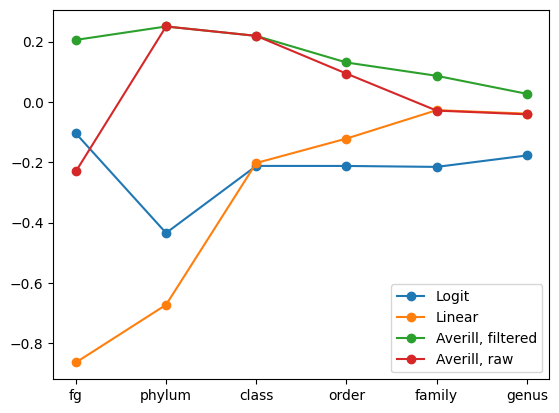

In [ ]:
class LogitRegression(LinearRegression):

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        y = np.nan_to_num(y, nan=0)
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)

models = {
    "Logit": LogitRegression(),
    "Linear": LinearRegression()
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, k_fold=5)
graph_results(models, results)
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.01, k_fold=5)
graph_results(models, results)

#### Decision Tree

Decision tree: [-3.3175081511624653, -0.8125336961751444, -1.2471325946086012, -1.7924161762436412, -1.3522899031294735, -5.03042467148747]


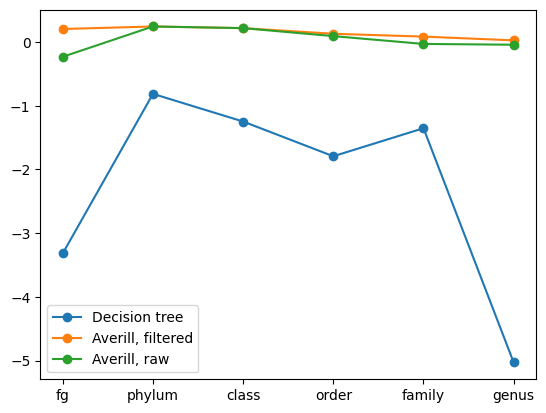

Decision tree: [-1.7176622648519757, -0.5511490225562189, -1.6043071624778666, -1.489889061793733, -1.2991976252577966, -1.617097737418106]


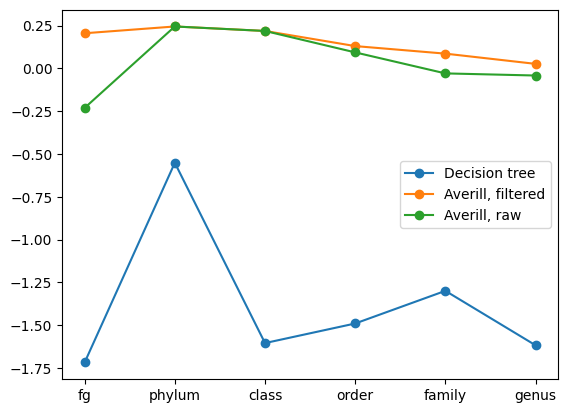

In [ ]:
models = {
    "Decision tree": DecisionTreeRegressor()
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, k_fold=5)
graph_results(models, results)
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.01, k_fold=5)
graph_results(models, results)

d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
130 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\stage\micropyome\venv\Lib\site-package

2024-07-10T17:08:24.728404 > INFO Evaluating 1 models with 5 splits.
2024-07-10T17:08:24.731402 > INFO K-fold split: 0
2024-07-10T17:08:24.735405 > INFO Beginning the evaluation of 1 models.
2024-07-10T17:08:24.743858 > INFO -1.0518247199708408
2024-07-10T17:08:24.746621 > INFO K-fold split: 1
2024-07-10T17:08:24.749139 > INFO Beginning the evaluation of 1 models.
2024-07-10T17:08:24.758999 > INFO -0.0944170338146148
2024-07-10T17:08:24.761403 > INFO K-fold split: 2
2024-07-10T17:08:24.765404 > INFO Beginning the evaluation of 1 models.
2024-07-10T17:08:24.773865 > INFO 0.021596853987219628
2024-07-10T17:08:24.776439 > INFO K-fold split: 3
2024-07-10T17:08:24.780092 > INFO Beginning the evaluation of 1 models.
2024-07-10T17:08:24.790354 > INFO -0.10939153042189724
2024-07-10T17:08:24.792359 > INFO K-fold split: 4
2024-07-10T17:08:24.795358 > INFO Beginning the evaluation of 1 models.
2024-07-10T17:08:24.803875 > INFO -0.22939724537648454
2024-07-10T17:08:24.807037 > INFO Evaluating 1 m

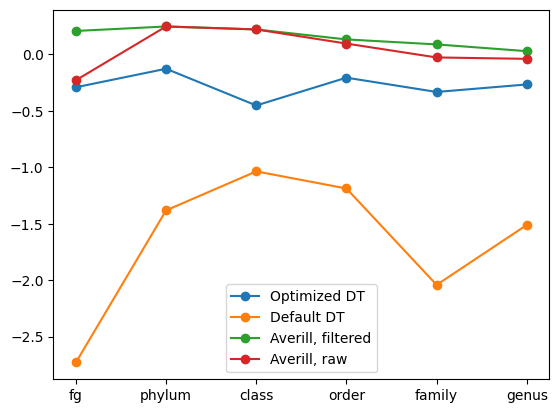

In [ ]:
meta_params = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': list(range(1, 8)),
    'min_samples_leaf': list(range(1, 8)),
    'max_features': [None, 'auto', 'sqrt', 'log2', 0.5, 0.8]
}

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

custom_r2_scorer = make_scorer(
    lambda o, p: np.mean(regression.r2_score_by_column(o, p)), greater_is_better=True
)

params = {}
for level in regression.TAXONOMIC_LEVELS:
    model = DecisionTreeRegressor()
    search = RandomizedSearchCV(model, meta_params, n_iter=100, cv=5, scoring=custom_r2_scorer, n_jobs=-1, verbose=0)
    x_train, x_test, y_train, y_test = train_test_split(X[level], Y[level], test_size=0.2)
    search.fit(x_train, y_train)
    params[level] = search.best_params_

results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model = DecisionTreeRegressor(**params[level])
    r = regression.train_evaluate_models(
        {"Optimized DT": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Optimized DT"] = r["Optimized DT"]
    model = DecisionTreeRegressor()
    r = regression.train_evaluate_models(
        {"Default DT": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Default DT"] = r["Default DT"]

graph_results(["Optimized DT", "Default DT"], results)

2024-07-10T17:08:52.275023 > INFO Evaluating 1 models with 5 splits.
2024-07-10T17:08:52.278094 > INFO K-fold split: 0
2024-07-10T17:08:52.281488 > INFO Beginning the evaluation of 1 models.
2024-07-10T17:08:52.288721 > INFO -0.16286592696781782
2024-07-10T17:08:52.291722 > INFO K-fold split: 1
2024-07-10T17:08:52.295941 > INFO Beginning the evaluation of 1 models.
2024-07-10T17:08:52.305059 > INFO -1.5690330053764312
2024-07-10T17:08:52.306975 > INFO K-fold split: 2
2024-07-10T17:08:52.310810 > INFO Beginning the evaluation of 1 models.
2024-07-10T17:08:52.322224 > INFO -0.1327610277247442
2024-07-10T17:08:52.324226 > INFO K-fold split: 3
2024-07-10T17:08:52.327352 > INFO Beginning the evaluation of 1 models.
2024-07-10T17:08:52.334911 > INFO 0.09251529547492848
2024-07-10T17:08:52.337419 > INFO K-fold split: 4
2024-07-10T17:08:52.340418 > INFO Beginning the evaluation of 1 models.
2024-07-10T17:08:52.347504 > INFO -0.17019873368870594
2024-07-10T17:08:52.349752 > INFO Evaluating 1 mo

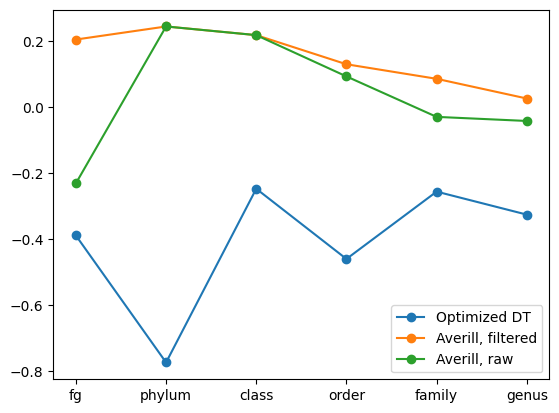

2024-07-10T17:08:53.032875 > INFO Evaluating 1 models with 5 splits.
2024-07-10T17:08:53.034910 > INFO K-fold split: 0
2024-07-10T17:08:53.038433 > INFO Beginning the evaluation of 1 models.
2024-07-10T17:08:53.045796 > INFO Dropped 1 columns.
2024-07-10T17:08:53.051477 > INFO 0.010864862630393813
2024-07-10T17:08:53.052580 > INFO K-fold split: 1
2024-07-10T17:08:53.057047 > INFO Beginning the evaluation of 1 models.
2024-07-10T17:08:53.064071 > INFO Dropped 2 columns.
2024-07-10T17:08:53.069227 > INFO -0.1374098772561331
2024-07-10T17:08:53.070572 > INFO K-fold split: 2
2024-07-10T17:08:53.074127 > INFO Beginning the evaluation of 1 models.
2024-07-10T17:08:53.081329 > INFO Dropped 2 columns.
2024-07-10T17:08:53.086372 > INFO -0.05481379682227966
2024-07-10T17:08:53.089900 > INFO K-fold split: 3
2024-07-10T17:08:53.094430 > INFO Beginning the evaluation of 1 models.
2024-07-10T17:08:53.099945 > INFO Dropped 2 columns.
2024-07-10T17:08:53.105821 > INFO -0.07905532452932823
2024-07-10T1

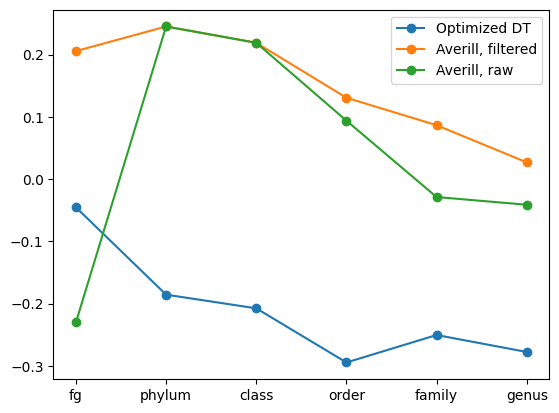

In [ ]:
results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model = DecisionTreeRegressor(**params[level])
    r = regression.train_evaluate_models(
        {"Optimized DT": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Optimized DT"] = r["Optimized DT"]

graph_results(["Optimized DT"], results)


results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model = DecisionTreeRegressor(**params[level])
    r = regression.train_evaluate_models(
        {"Optimized DT": model}, X[level], Y[level], threshold=0.01, k_fold=5
    )
    results[level]["Optimized DT"] = r["Optimized DT"]

graph_results(["Optimized DT"], results)

#### Random Forest

d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
270 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\stage\micropyome\venv\Lib\site-packa

Optimized RF: [0.02567201670041643, 0.11740153383270757, 0.11620027842314976, 0.056091279317963746, 0.016762710206060755, 0.06186092114529731]
Default RF: [-0.09000497439418192, 0.11977326767893874, 0.07259337899441934, 0.02011161905596808, -0.32454329661601966, -0.04875085091926643]


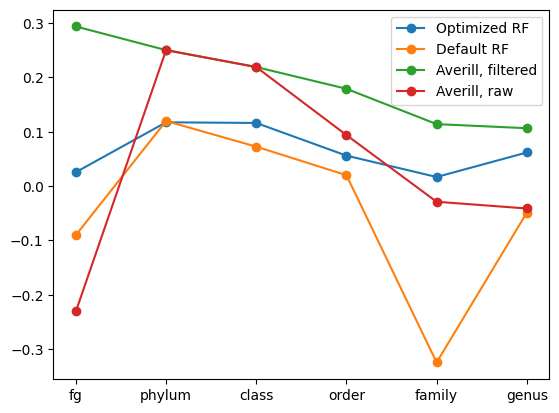

In [ ]:
meta_params = {
    'n_estimators': list(range(60, 120)),  # Close to default of 100
    'max_depth': [None, 5, 10, 20, 30],  # Default is None
    'min_samples_split': list(range(1, 8)),  # Default is 2
    'min_samples_leaf': list(range(1, 5)),  # Default is 1
    'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.8]  # Default is 'auto'
}

params = {}
for level in regression.TAXONOMIC_LEVELS:
    model = RandomForestRegressor()
    search = RandomizedSearchCV(model, meta_params, n_iter=200, cv=5, scoring=custom_r2_scorer, n_jobs=-1, verbose=0)
    x_train, x_test, y_train, y_test = train_test_split(X[level], Y[level], test_size=0.2)
    search.fit(x_train, y_train)
    params[level] = search.best_params_

results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model = RandomForestRegressor(**params[level])
    r = regression.train_evaluate_models(
        {"Optimized RF": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Optimized RF"] = r["Optimized RF"]
    model = RandomForestRegressor()
    r = regression.train_evaluate_models(
        {"Default RF": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Default RF"] = r["Default RF"]

graph_results(["Optimized RF", "Default RF"], results)

Optimized RF: [0.08435058783600893, 0.2279209013484965, 0.05757234668210567, -0.00968746612200207, -0.09539588945158664, 0.01737304570501595]
Default RF: [-0.23049164580659692, 0.17451447390591995, -0.09306868586257541, -0.004592829298207643, -0.05144048455589854, -0.32509164969390325]


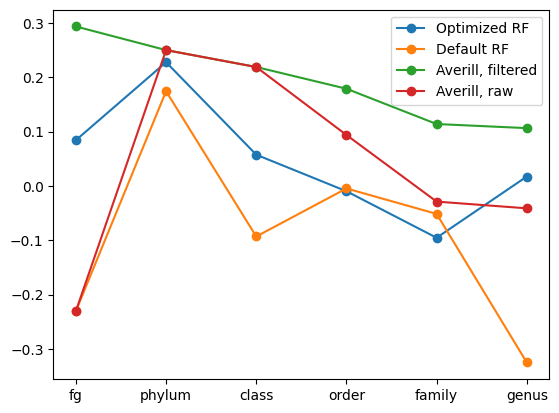

In [ ]:
# log.enable()

results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model = RandomForestRegressor(**params[level])
    r = regression.train_evaluate_models_random(
        {"Optimized RF": model}, X[level], Y[level], fraction=0.16, threshold=0.0
    )
    results[level]["Optimized RF"] = r["Optimized RF"]
    model = RandomForestRegressor()
    r = regression.train_evaluate_models_random(
        {"Default RF": model}, X[level], Y[level], fraction=0.16, threshold=0.0
    )
    results[level]["Default RF"] = r["Default RF"]

graph_results(["Optimized RF", "Default RF"], results)
# graph_results(["Default RF"], results)

In [ ]:
results = {}
for iteration in range(10):
    for level in regression.TAXONOMIC_LEVELS:
        X_train, X_test, y_train, y_test = train_test_split(X[level], Y[level], test_size=0.16)
        r = regression.evaluate_models({"RF": RandomForestRegressor()}, X_train, y_train, X_test, y_test, threshold = 0.012)
        v = np.mean(r["RF"])
        if level in results:
            results[level].append(v)
        else:
            results[level] = [v]

for level in regression.TAXONOMIC_LEVELS:
    print(level, "    ", np.mean(results[level]), "    ", results[level])

fg      0.20265355406875957      [-0.2422243861251565, 0.3401144777042987, 0.26362967233927104, 0.2512812667870515, 0.11891179853328793, 0.2515111666452382, 0.25244507889202034, 0.32546224834242365, 0.1662240658651037, 0.29918015170405704]
phylum      0.09001307730919106      [0.28132763380175596, 0.09941153887187557, 0.0949809466133977, -0.2610261417699796, 0.11986197185140546, 0.27411411980937145, -0.06592040635461052, 0.06965343478310096, -0.04780365478811471, 0.33553133027370835]
class      -0.11354648749964107      [0.08069479352530826, -0.17368002403975677, -0.4591607713442281, -0.40656834636347955, -0.5448411158523901, 0.12874742377525497, 0.25995973804162054, -0.06029665247387286, 0.05216848562108641, -0.012488405885953324]
order      0.005213844227077692      [0.05151889294060572, 0.12517620517584238, -0.02140550758589848, 0.04237135655112549, 0.17975422310705444, -0.020503947609073696, -0.03751954161574109, 0.1474059443866121, -0.3969038580140158, -0.01775532506573411]
family

#### Gradient Boosting

In [ ]:
meta_params = {
    'estimator__n_estimators': list(range(80, 120)),  # Close to default of 100
    'estimator__learning_rate': [0.05, 0.1, 0.15, 0.2],  # Default is 0.1
    'estimator__max_depth': [3, 4, 5, 6, 7, 8],  # Default is 3
    'estimator__min_samples_split': list(range(1, 10)),  # Default is 2
    'estimator__min_samples_leaf': list(range(1, 6)),  # Default is 1
    'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.8],  # Default is None
    'estimator__subsample': [0.6, 0.7, 0.8, 0.9, 1.0]  # Default is 1.0
}

params = {}
for level in regression.TAXONOMIC_LEVELS:
    model =  MultiOutputRegressor(GradientBoostingRegressor())
    search = RandomizedSearchCV(model, meta_params, n_iter=100, cv=5, scoring=custom_r2_scorer, n_jobs=-1, verbose=0)
    x_train, x_test, y_train, y_test = train_test_split(X[level], Y[level], test_size=0.2)
    search.fit(x_train, y_train)
    params[level] = search.best_params_

d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
65 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
65 fits failed with the following error:
Traceback (most recent call last):
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\multioutput.py", line 272, in fit
    self.estimators_ = Pa

{'fg': {'subsample': 0.6, 'n_estimators': 97, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.05}, 'phylum': {'subsample': 0.7, 'n_estimators': 93, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 0.8, 'max_depth': 5, 'learning_rate': 0.05}, 'class': {'subsample': 0.9, 'n_estimators': 87, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 6, 'learning_rate': 0.05}, 'order': {'subsample': 0.6, 'n_estimators': 94, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 7, 'learning_rate': 0.05}, 'family': {'subsample': 0.7, 'n_estimators': 94, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 6, 'learning_rate': 0.05}, 'genus': {'subsample': 0.8, 'n_estimators': 82, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.05}}
Optimized GB: [-0.0317554498137021, -0.1087140025

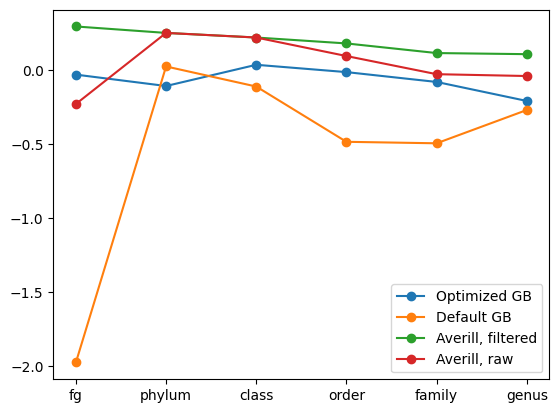

In [ ]:
renamed_params = {}
for level in params:
    renamed_params[level] = {}
    for param in params[level]:
        new_param = param.split("__")[-1]
        renamed_params[level][new_param] = params[level][param]
print(renamed_params)

results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model =  MultiOutputRegressor(GradientBoostingRegressor(**renamed_params[level]))
    r = regression.train_evaluate_models(
        {"Optimized GB": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Optimized GB"] = r["Optimized GB"]
    model = MultiOutputRegressor(GradientBoostingRegressor())
    r = regression.train_evaluate_models(
        {"Default GB": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Default GB"] = r["Default GB"]

graph_results(["Optimized GB", "Default GB"], results)

Optimized GB: [0.18294837351260984, 0.04413634979181782, -0.05085158563045124, -0.0861384578162983, -0.02478580521966021, 0.045360812458316246]


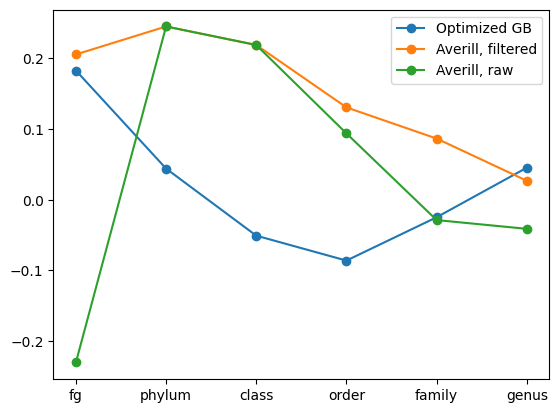

In [ ]:
results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model =  MultiOutputRegressor(GradientBoostingRegressor(**renamed_params[level]))
    r = regression.train_evaluate_models(
        {"Optimized GB": model}, X[level], Y[level], threshold=0.012, k_fold=5
    )
    results[level]["Optimized GB"] = r["Optimized GB"]

graph_results(["Optimized GB"], results)

#### k-NN

k-10: [0.05605121417929008, 0.004169923303921347, -0.001834691783060259, -0.029856387501471588, -0.08057966325514365, -0.22659436914694328]
k-20: [0.06000779901675453, -0.059716840619886156, 0.04321680644372873, 0.02307008187176653, -0.010078049334003726, -0.17888217265359285]
k-10-d: [0.08099349377712758, 0.045231103889830745, 0.0006600820972612754, -0.017706984452968193, -0.05368482670281196, -0.1602649608800185]
k-20-d: [0.08776559119248188, -0.0030770310477821194, 0.06340897199148111, 0.044118819530633534, 0.015466145355327265, -0.12612616743965893]


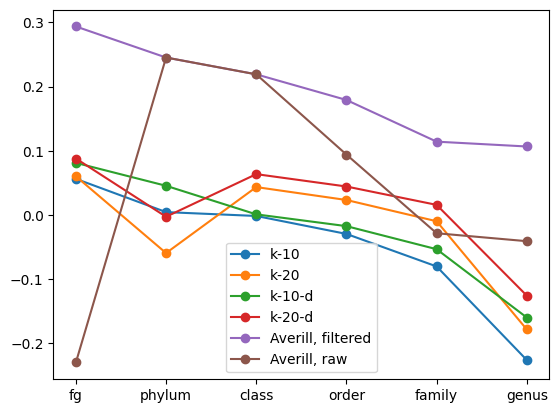

k-10: [0.11584968220176742, 0.08761649657094706, 0.07066388684007668, 0.028767210764845213, -0.017465950301608905, 0.04402148060386033]
k-20: [0.12209440894070075, 0.08293316746891297, 0.06567262550760775, 0.04492000108882721, 0.011459540371220897, 0.04007340129170311]
k-10-d: [0.1375133419274211, 0.12083085319307829, 0.08831748818695007, 0.05117542273875351, 0.0010434618371699567, 0.07097670731539223]
k-20-d: [0.14884850669425526, 0.12568018208500484, 0.09104872667516964, 0.07228224649300516, 0.03644486369313037, 0.06786193287652949]


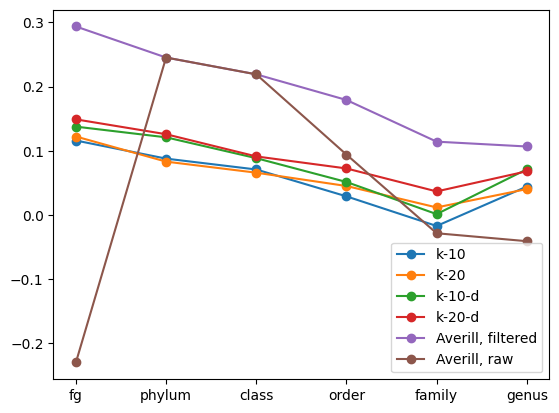

In [ ]:
models = {
    "k-10": KNeighborsRegressor(10),
    "k-20": KNeighborsRegressor(20),
    "k-10-d": KNeighborsRegressor(10, weights="distance"),
    "k-20-d": KNeighborsRegressor(20, weights="distance"),
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, k_fold=5)
graph_results(models, results)
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.01, k_fold=5)
graph_results(models, results)

## NEON Data

### Fungal Taxa Predictions

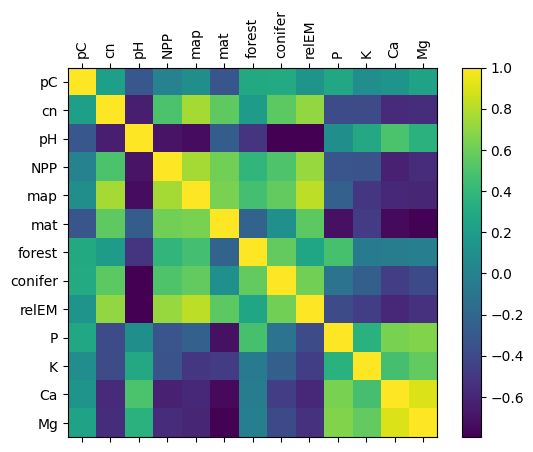

In [33]:
from micropyome.datasets import normalize, normalize_categories

TRANSFER_DATASET_PATH = "../data/neon/fungi/"
SAMPLING_LEVELS = ["core", "plot", "site"]

X = {}
Y = {}
Y2 = {}

for level in regression.TAXONOMIC_LEVELS:
    X[level] = {}
    Y[level] = {}
    Y2[level] = {}
    x = pd.read_csv(f"{TRANSFER_DATASET_PATH}/Variables/{level}_core_13Var.csv", delimiter=";")
    x = x.drop(x.columns[0], axis=1)
    x = normalize(x)
    y = pd.read_csv(f"{TRANSFER_DATASET_PATH}/Observed/{level}_core_observed.csv")
    y = y.drop(y.columns[0], axis=1)
    y = normalize_categories(y)
    z = pd.read_csv(f"{TRANSFER_DATASET_PATH}/Predicted/{level}_core_predicted.csv")
    z = z.drop(z.columns[0], axis=1)
    z = normalize_categories(z)
    X[level] = x
    Y[level] = y
    Y2[level] = z


view_autocorrelation(X["fg"], "neon_fungi.eps")

In [32]:
raw_published_results = []
for level in regression.TAXONOMIC_LEVELS:
    r = regression.r2_score_by_column(Y[level], Y2[level])
    raw_published_results.append(np.mean(r))

published_results = []
for level in regression.TAXONOMIC_LEVELS:
    y, y2 = Y[level], Y2[level]
    threshold = 0.01
    for column in y.columns:
        if y[column].mean() < 0.01:
            y = y.drop(columns=[column])
            y2 = y2.drop(columns=["mean." + column])
    r = regression.r2_score_by_column(y, y2)
    published_results.append(np.mean(r))

print("Raw published results: ", raw_published_results)
print("Published results: ", published_results)


def graph_results(models: dict, results: dict):
    x = list(range(len(regression.TAXONOMIC_LEVELS)))

    for model in models:
        y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
        print(f"{model}: {y}")
        plt.plot(x, y, "-o", label=model)

    plt.plot(x, published_results, "-o", label="Averill, filtered")

    plt.xticks(x, regression.TAXONOMIC_LEVELS)
    plt.legend()
    plt.show()

Raw published results:  [-1.6267933925463198, -0.5033242348316628, -1.8851452380286347, -6.0319270033666985, -1.3027986215287682e+32, -2.305791205607328e+32]
Published results:  [-0.1185652895373612, -0.5033242348316628, -1.1300106505128609, -0.189889386877197, -0.31207666553627655, -0.46704081417190374]


#### Logit

Logit: [0.26665594446626073, 0.25378571558241386, 0.22736539112228601, 0.06842071592542164, -2.8035440286782646e+28, -2.4597093701689756e+28]
Linear: [0.31570460786974985, 0.29178685671980664, 0.24086432489839743, 0.022909469308146097, -3.007666170066542e+26, -1.552544444936725e+27]


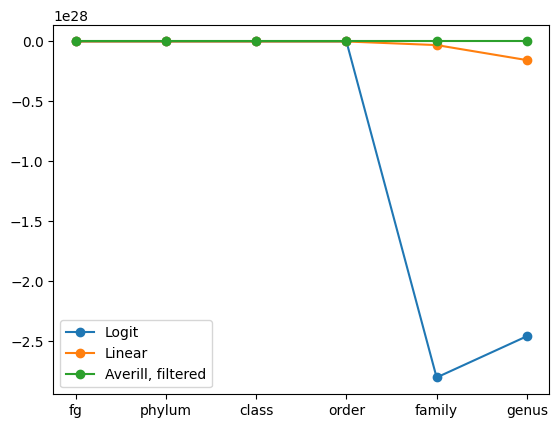

Logit: [0.3246190512978892, 0.24020431630072547, 0.2286261912515175, 0.1247511679285451, -0.001039076149711965, -0.01366810227347869]
Linear: [0.3841346056980867, 0.2914741829944188, 0.28339105184094054, 0.16523460621368707, 0.09500296197878139, 0.11306320266882293]


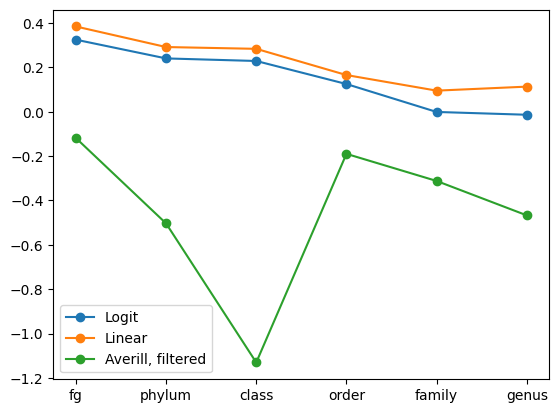

In [5]:
class LogitRegression(LinearRegression):

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        y = np.nan_to_num(y, nan=0)
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)

models = {
    "Logit": LogitRegression(),
    "Linear": LinearRegression()
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, k_fold=5)
graph_results(models, results)
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.01, k_fold=5)
graph_results(models, results)

#### Decision Tree

d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
140 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
85 fits failed with the following error:
Traceback (most recent call last):
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\stage\micropyome\venv\Lib\site-package

Optimized DT: [0.2711725492220014, 0.28113855432909407, 0.1799188401772083, -0.0008826358543734369, -0.461326919803504, -7.734735378901282e+30]
Default DT: [-0.12654113039371392, -0.3803335327363094, -0.4274501377543431, -1.512716370185875, -2.907866119394086, -7.420382253895697e+28]


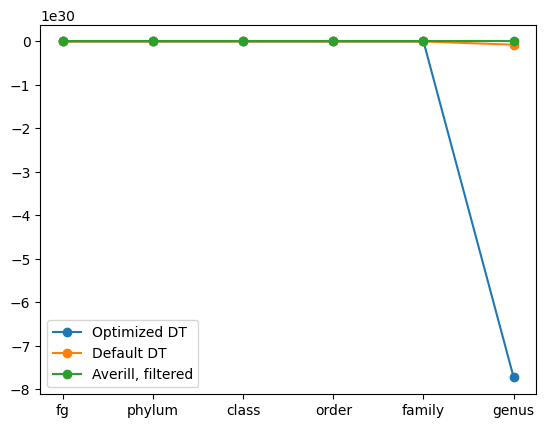

In [ ]:
meta_params = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': list(range(1, 8)),
    'min_samples_leaf': list(range(1, 8)),
    'max_features': [None, 'auto', 'sqrt', 'log2', 0.5, 0.8]
}

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

custom_r2_scorer = make_scorer(
    lambda o, p: np.mean(regression.r2_score_by_column(o, p)), greater_is_better=True
)

params = {}
for level in regression.TAXONOMIC_LEVELS:
    model = DecisionTreeRegressor()
    search = RandomizedSearchCV(model, meta_params, n_iter=100, cv=5, scoring=custom_r2_scorer, n_jobs=-1, verbose=0)
    x_train, x_test, y_train, y_test = train_test_split(X[level], Y[level], test_size=0.2)
    search.fit(x_train, y_train)
    params[level] = search.best_params_

results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model = DecisionTreeRegressor(**params[level])
    r = regression.train_evaluate_models(
        {"Optimized DT": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Optimized DT"] = r["Optimized DT"]
    model = DecisionTreeRegressor()
    r = regression.train_evaluate_models(
        {"Default DT": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Default DT"] = r["Default DT"]

graph_results(["Optimized DT", "Default DT"], results)

Optimized DT: [0.34874095162905033, 0.28050635883983627, 0.30444906767014807, 0.04011032321273852, 0.054161578711954296, -0.2902874900906859]


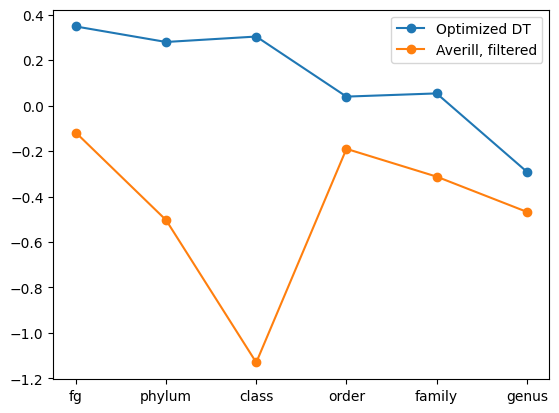

In [ ]:
results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model = DecisionTreeRegressor(**params[level])
    r = regression.train_evaluate_models(
        {"Optimized DT": model}, X[level], Y[level], threshold=0.01, k_fold=5
    )
    results[level]["Optimized DT"] = r["Optimized DT"]

graph_results(["Optimized DT"], results)

#### Random Forest

d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
325 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\stage\micropyome\venv\Lib\site-packag

Optimized RF: [0.3503233377863693, 0.36028467504140455, 0.2239421903881837, 0.13926343499507604, -0.25071068766387306, -7.764092284693009e+27]
Default RF: [0.36364410986110046, 0.28342186571968636, 0.13947940480744286, -0.3340819178059233, -1.1796836231911627, -3.169949565217572e+27]


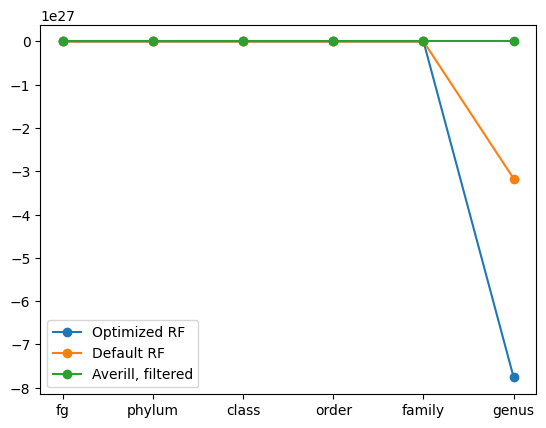

In [ ]:
meta_params = {
    'n_estimators': list(range(60, 120)),  # Close to default of 100
    'max_depth': [None, 5, 10, 20, 30],  # Default is None
    'min_samples_split': list(range(1, 8)),  # Default is 2
    'min_samples_leaf': list(range(1, 5)),  # Default is 1
    'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.8]  # Default is 'auto'
}

params = {}
for level in regression.TAXONOMIC_LEVELS:
    model = RandomForestRegressor()
    search = RandomizedSearchCV(model, meta_params, n_iter=200, cv=5, scoring=custom_r2_scorer, n_jobs=-1, verbose=0)
    x_train, x_test, y_train, y_test = train_test_split(X[level], Y[level], test_size=0.2)
    search.fit(x_train, y_train)
    params[level] = search.best_params_

results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model = RandomForestRegressor(**params[level])
    r = regression.train_evaluate_models(
        {"Optimized RF": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Optimized RF"] = r["Optimized RF"]
    model = RandomForestRegressor()
    r = regression.train_evaluate_models(
        {"Default RF": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Default RF"] = r["Default RF"]

graph_results(["Optimized RF", "Default RF"], results)

Optimized RF: [0.4549254169247302, 0.339750130875638, 0.3440631703044642, 0.21081494278451668, 0.14614663540496736, 0.039078117638533375]
Default RF: [0.3938709392738386, 0.271816158787935, 0.28208494439001675, -0.04316211781379363, -0.01811893282264406, 0.07724226023282957]


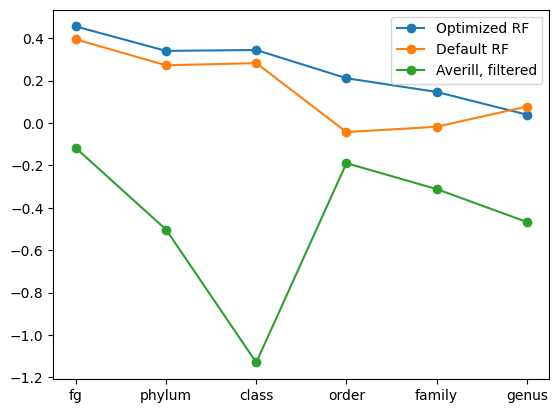

In [ ]:
results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model = RandomForestRegressor(**params[level])
    r = regression.train_evaluate_models(
        {"Optimized RF": model}, X[level], Y[level], threshold=0.01, k_fold=5
    )
    results[level]["Optimized RF"] = r["Optimized RF"]
    model = RandomForestRegressor()
    r = regression.train_evaluate_models(
        {"Default RF": model}, X[level], Y[level], threshold=0.01, k_fold=5
    )
    results[level]["Default RF"] = r["Default RF"]

graph_results(["Optimized RF", "Default RF"], results)

#### Gradient Boosting

In [16]:
meta_params = {
    'estimator__n_estimators': list(range(80, 120)),  # Close to default of 100
    'estimator__learning_rate': [0.05, 0.1, 0.15, 0.2],  # Default is 0.1
    'estimator__max_depth': [3, 4, 5, 6, 7, 8],  # Default is 3
    'estimator__min_samples_split': list(range(1, 10)),  # Default is 2
    'estimator__min_samples_leaf': list(range(1, 6)),  # Default is 1
    'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.8],  # Default is None
    'estimator__subsample': [0.6, 0.7, 0.8, 0.9, 1.0]  # Default is 1.0
}

params = {}
for level in regression.TAXONOMIC_LEVELS:
    model =  MultiOutputRegressor(GradientBoostingRegressor())
    search = RandomizedSearchCV(model, meta_params, n_iter=100, cv=5, scoring=custom_r2_scorer, n_jobs=-1, verbose=0)
    x_train, x_test, y_train, y_test = train_test_split(X[level], Y[level], test_size=0.2)
    search.fit(x_train, y_train)
    params[level] = search.best_params_

d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
55 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\multioutput.py", line 272, in fit
    self.estimators_ = Pa

Optimized GB: [0.3545478320000178, 0.28364300765077477, 0.17265884172886375, -0.023209616976284292, -6.37531655460684e+26, -4.181524195760782e+27]


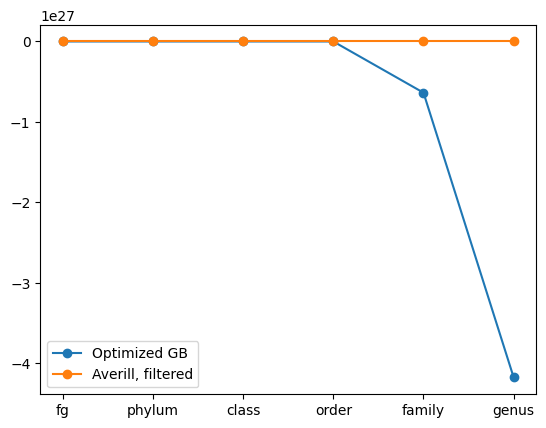

Optimized GB: [0.4093756292219113, 0.2767600548680055, 0.28635494634970876, 0.10289545185288866, 0.1323688152947946, 0.04740183423647913]


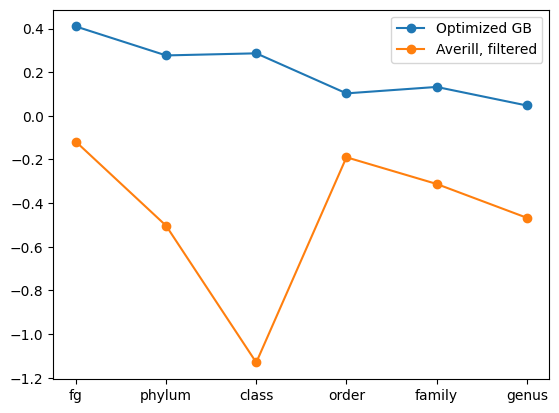

In [17]:
results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model =  MultiOutputRegressor(GradientBoostingRegressor(**renamed_params[level]))
    r = regression.train_evaluate_models(
        {"Optimized GB": model}, X[level], Y[level], threshold=0.00, k_fold=5
    )
    results[level]["Optimized GB"] = r["Optimized GB"]

graph_results(["Optimized GB"], results)


results = {}
for level in regression.TAXONOMIC_LEVELS:
    results[level] = {}
    model =  MultiOutputRegressor(GradientBoostingRegressor(**renamed_params[level]))
    r = regression.train_evaluate_models(
        {"Optimized GB": model}, X[level], Y[level], threshold=0.01, k_fold=5
    )
    results[level]["Optimized GB"] = r["Optimized GB"]

graph_results(["Optimized GB"], results)

#### k-NN

k-10: [0.2981629939992886, 0.2919244290696533, 0.19784523350800706, -0.3653274244510509, -0.09663829730591124, -6.05164435336731e+26]
k-20: [0.2966288461096115, 0.3179127007236824, 0.24734913210790302, -0.21488477306112336, -0.017037006416640958, -4.439484261753284e+26]
k-10-d: [0.28458300159121136, 0.3193974064476205, 0.17153032005699845, -0.5150465237050359, -0.30944937161647623, -6.776876997644417e+26]
k-20-d: [0.29575444485206326, 0.3302147670060975, 0.20770321233616693, -0.3845849146723671, -0.23559380480933179, -2.2425275638597144e+26]


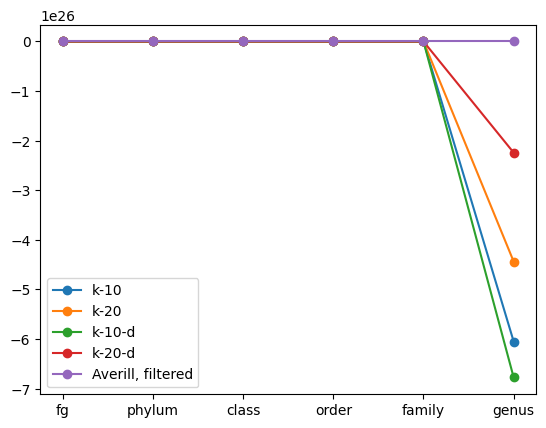

k-10: [0.3995116059113074, 0.2321873271685054, 0.2980869566099701, 0.12295572207686208, 0.11499585945333357, 0.0854757935291536]
k-20: [0.395437202576883, 0.2687286884798468, 0.322339474197442, 0.16851431764808228, 0.12160654849144228, 0.11963042411020278]
k-10-d: [0.39619216224521947, 0.18869803691853582, 0.2797438812852122, 0.05281142129521956, 0.020406915691415832, -0.017458154833881273]
k-20-d: [0.4002174654030453, 0.22097482405838834, 0.3014790855122511, 0.08370091110402292, 0.036880096881829916, 0.029249831744402516]


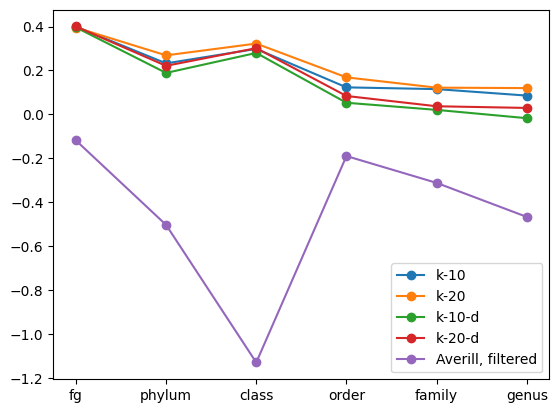

In [ ]:
models = {
    "k-10": KNeighborsRegressor(10),
    "k-20": KNeighborsRegressor(20),
    "k-10-d": KNeighborsRegressor(10, weights="distance"),
    "k-20-d": KNeighborsRegressor(20, weights="distance"),
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, k_fold=5)
graph_results(models, results)
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.01, k_fold=5)
graph_results(models, results)

# NEON Bacteria

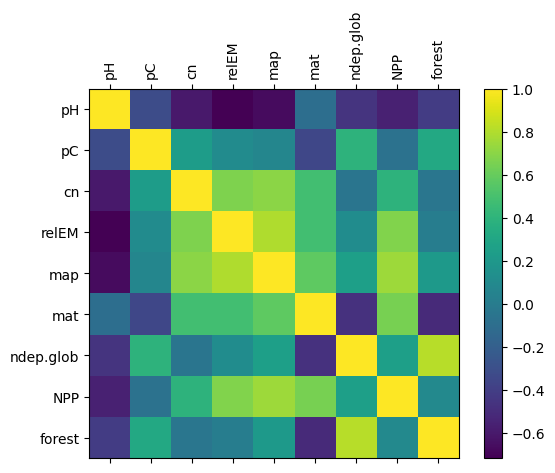

In [36]:
DATASET_PATH = "../data/neon/bacteria/"
X = {}
Y = {}
for level in regression.TAXONOMIC_LEVELS:
    if level == 'fg':
        continue
    x = pd.read_csv(f"{DATASET_PATH}var_sorted.csv", sep=";")
    y = pd.read_csv(f"{DATASET_PATH}Observed/{level}.csv", sep=";")

    x = x.drop(columns=x.columns[:5], axis=1)
    if "deprecatedVialID" in x.columns:
        x = x.drop("deprecatedVialID", axis=1)
    scaler = StandardScaler()
    x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
    y = y.drop(y.columns[0], axis=1)

    X[level] = x
    Y[level] = y


view_autocorrelation(X["phylum"], "neon_bacteria_autocorrelation.eps")


def graph_results(models: dict, results: dict):
    x = list(range(len(regression.TAXONOMIC_LEVELS[1:])))

    for model in models:
        y = [results[level][model] for level in regression.TAXONOMIC_LEVELS[1:]]
        print(f"{model}: {y}")
        plt.plot(x, y, "-o", label=model)

    plt.xticks(x, regression.TAXONOMIC_LEVELS[1:])
    plt.legend()
    plt.show()

In [18]:
X["genus"].head()

,pH,pC,cn,relEM,map,mat,ndep.glob,NPP,forest
0,-0.697596,1.828972,0.966767,0.187306,0.630194,-1.030877,-0.218908,-0.581253,0.740887
1,-0.697596,1.828972,0.966767,0.187306,0.630194,-1.030877,-0.218908,-0.581253,0.740887
2,-0.697596,1.828972,0.966767,0.187306,0.630194,-1.030877,-0.218908,-0.581253,0.740887
3,-0.769849,1.570338,1.007350,0.059813,0.630194,-1.030877,-0.218908,-0.581253,0.740887
4,-0.769849,1.570338,1.007350,0.059813,0.630194,-1.030877,-0.218908,-0.581253,0.740887


In [19]:
Y["genus"].head()

,other,bacillus,bradyrhizobium,chthoniobacter,devosia,mycobacterium,opitutus,phenylobacterium,pseudomonas,rhodoplanes,sphingomonas
0,0.961884,0.000599,0.004390,0.000200,0.000399,0.000399,0.003792,0.000399,0.000200,0.027539,0.0002
1,0.960487,0.000599,0.010377,0.000798,0.000200,0.000599,0.000798,0.001596,0.000798,0.023548,0.0002
2,0.938934,0.000200,0.003991,0.000798,0.000200,0.000798,0.005189,0.000200,0.000200,0.049292,0.0002
3,0.954500,0.000798,0.009379,0.000200,0.000200,0.000599,0.000200,0.000200,0.016763,0.016963,0.0002
4,0.947515,0.000998,0.018559,0.000798,0.000200,0.001796,0.000599,0.003193,0.000200,0.025943,0.0002


#### k-NN

k-10: [0.4351591932339109, 0.44972603937300093, 0.4188785506167478, 0.35992976558548306, 0.32819349147828975]
k-20: [0.41674914677826697, 0.4232297779870936, 0.3907069633381348, 0.3330670042671251, 0.28656086275074755]
k-30: [0.39952427920050076, 0.3993049033782902, 0.3606712071302985, 0.32078422026177733, 0.270052835688679]


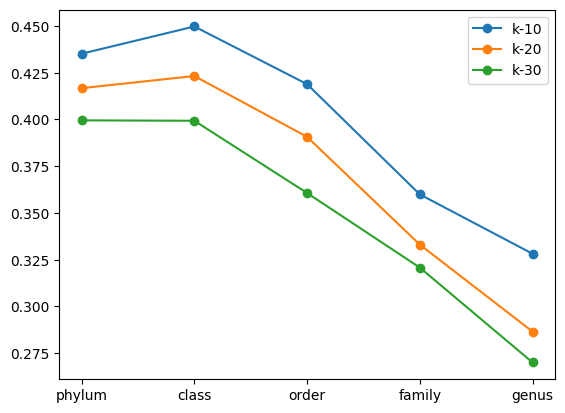

k-10: [0.43256392541284844, 0.41004337291936926, 0.3819373577560784, 0.24915568931860071, 0.19272853650316885]
k-20: [0.4124069854404935, 0.3864297170835137, 0.36412064288204116, 0.23305245925845286, 0.19833921966368817]
k-30: [0.3945571908177826, 0.36083734045213245, 0.3416080802641644, 0.24231900143737445, 0.20332293611851418]


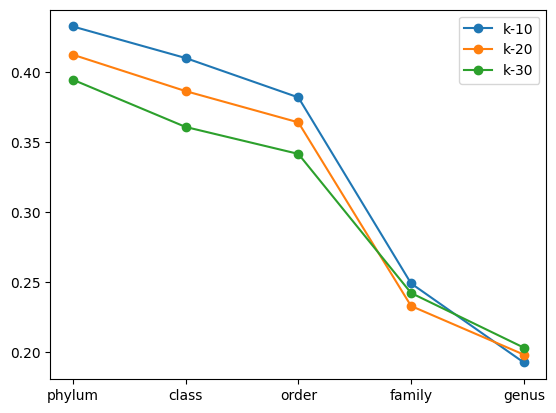

In [56]:
models = {
    "k-10": KNeighborsRegressor(10),
    "k-20": KNeighborsRegressor(20),
    "k-30": KNeighborsRegressor(30),
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)
graph_results(models, results)
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.0, k_fold=5)
graph_results(models, results)

#### Logit and Linear Regression

Logit: [0.35576367547865, 0.3611054058514285, 0.33886804029520734, 0.17346060082958129, 0.1165357919816636]
Linear: [0.3834033402099006, 0.3899805977983998, 0.35496554792179835, 0.05031000317424639, 0.17844135248228715]


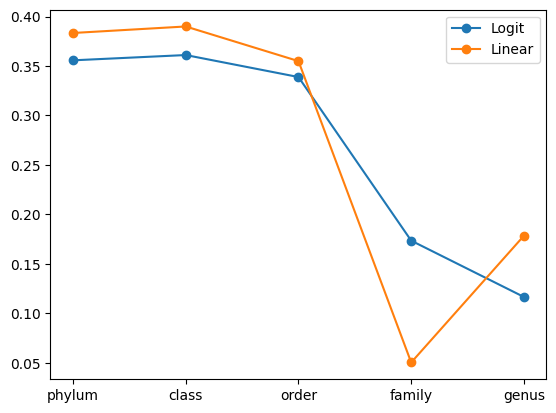

Logit: [0.3404159326185761, 0.3626214458987383, 0.31786166719923237, 0.23560328203354403, 0.17627221724479586]
Linear: [0.35669634073036904, 0.3859537418656246, 0.32897073379826125, 0.28816698159724113, 0.20437924109213168]


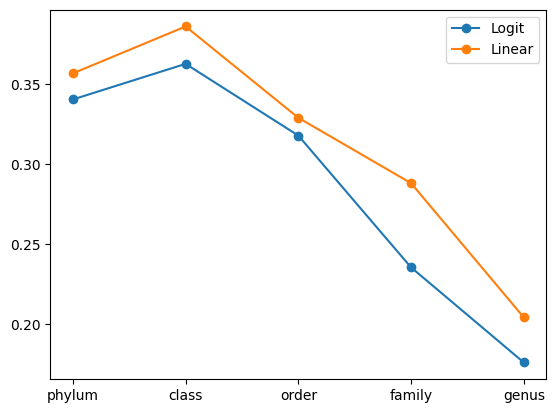

In [57]:
class LogitRegression(LinearRegression):

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        y = np.nan_to_num(y, nan=0)
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)


models = {
    "Logit": LogitRegression(),
    "Linear": LinearRegression()
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.0, k_fold=5)
graph_results(models, results)
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)
graph_results(models, results)

#### Decision Tree

Decision tree: [0.12399299310501359, -0.12362440876143119, 0.03561973133044077, -0.09587857848295792, -0.23322829116846217]


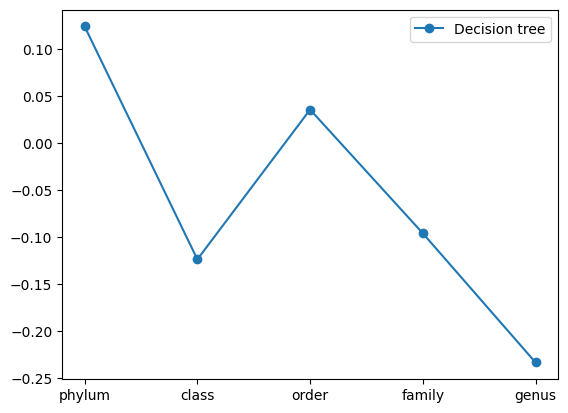

Decision tree: [0.1568594836006248, 0.1923846559771361, -0.13193908220870582, -3.625315965293008, -0.3648586512656261]


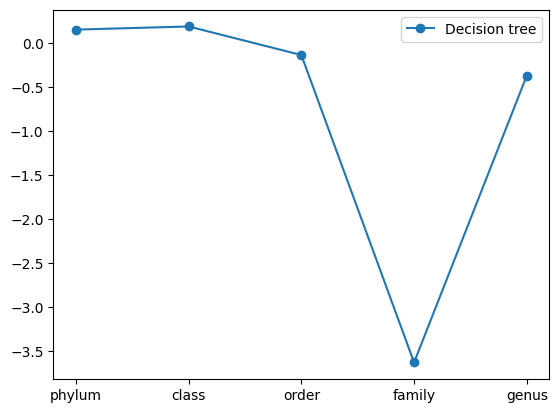

In [58]:
models = {
    "Decision tree": DecisionTreeRegressor()
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)
graph_results(models, results)
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.0, k_fold=5)
graph_results(models, results)

#### Random Forest

d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
195 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\stage\micropyome\venv\Lib\site-package

Optimized RF: [0.46492468119862285, 0.4562607714742608, 0.37935058295080026, 0.3578832509597134, 0.2655827018744982]
Default RF: [0.3760965577236843, 0.40204099141785266, 0.32875905211937434, 0.19872664195956286, 0.21547885689004884]


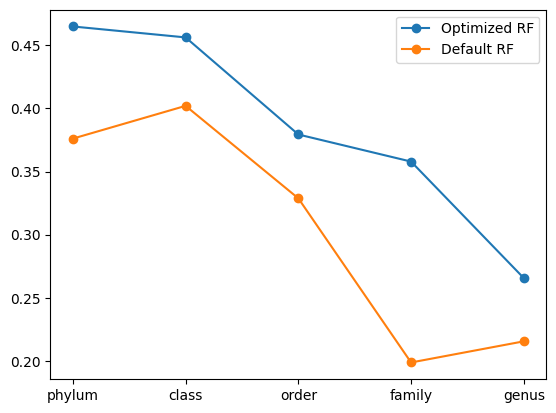

Optimized RF: [0.4163953998666239, 0.43253863920209323, 0.3927712659203388, 0.18666950058917087, 0.20751845972157343]
Default RF: [0.44175307690929194, 0.38225960199936976, 0.19784545916529614, -0.3272846737254952, 0.09818785520566847]


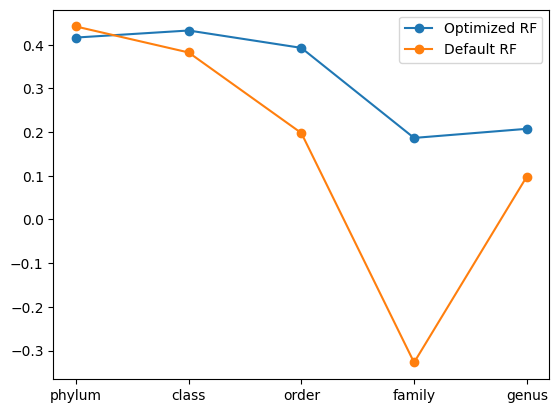

In [64]:
meta_params = {
    'n_estimators': list(range(80, 120)),  # Close to default of 100
    'max_depth': [None, 5, 10, 20, 30],  # Default is None
    'min_samples_split': list(range(1, 8)),  # Default is 2
    'min_samples_leaf': list(range(1, 5)),  # Default is 1
    'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.8]  # Default is 'auto'
}

from sklearn.metrics import make_scorer
custom_r2_scorer = make_scorer(
    lambda o, p: np.mean(regression.r2_score_by_column(o, p)), greater_is_better=True
)

params = {}
for level in regression.TAXONOMIC_LEVELS[1:]:
    model = RandomForestRegressor()
    search = RandomizedSearchCV(model, meta_params, n_iter=100, cv=5, scoring=custom_r2_scorer, n_jobs=-1, verbose=0)
    x_train, x_test, y_train, y_test = train_test_split(X[level], Y[level], test_size=0.2)
    search.fit(x_train, y_train)
    params[level] = search.best_params_

results = {}
for level in regression.TAXONOMIC_LEVELS[1:]:
    results[level] = {}
    model = RandomForestRegressor(**params[level])
    r = regression.train_evaluate_models(
        {"Optimized RF": model}, X[level], Y[level], k_fold=5, threshold=0.003
    )
    results[level]["Optimized RF"] = r["Optimized RF"]
    model = RandomForestRegressor()
    r = regression.train_evaluate_models(
        {"Default RF": model}, X[level], Y[level], k_fold=5, threshold=0.003
    )
    results[level]["Default RF"] = r["Default RF"]

graph_results(["Optimized RF", "Default RF"], results)

results = {}
for level in regression.TAXONOMIC_LEVELS[1:]:
    results[level] = {}
    model = RandomForestRegressor(**params[level])
    r = regression.train_evaluate_models(
        {"Optimized RF": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Optimized RF"] = r["Optimized RF"]
    model = RandomForestRegressor()
    r = regression.train_evaluate_models(
        {"Default RF": model}, X[level], Y[level], k_fold=5
    )
    results[level]["Default RF"] = r["Default RF"]

graph_results(["Optimized RF", "Default RF"], results)

#### Gradient Boosting

In [65]:
meta_params = {
    'estimator__n_estimators': list(range(80, 120)),  # Close to default of 100
    'estimator__learning_rate': [0.05, 0.1, 0.15, 0.2],  # Default is 0.1
    'estimator__max_depth': [3, 4, 5, 6, 7, 8],  # Default is 3
    'estimator__min_samples_split': list(range(1, 10)),  # Default is 2
    'estimator__min_samples_leaf': list(range(1, 6)),  # Default is 1
    'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.8],  # Default is None
    'estimator__subsample': [0.6, 0.7, 0.8, 0.9, 1.0]  # Default is 1.0
}

params = {}
for level in regression.TAXONOMIC_LEVELS[1:]:
    model =  MultiOutputRegressor(GradientBoostingRegressor())
    search = RandomizedSearchCV(model, meta_params, n_iter=100, cv=5, scoring=custom_r2_scorer, n_jobs=-1, verbose=0)
    x_train, x_test, y_train, y_test = train_test_split(X[level], Y[level], test_size=0.2)
    search.fit(x_train, y_train)
    params[level] = search.best_params_

d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\stage\micropyome\venv\Lib\site-packages\sklearn\multioutput.py", line 272, in fit
    self.estimators_ = Pa

Optimized GB: [0.4374492863454488, 0.45965197167662597, 0.36964331382107385, 0.35934957364636066, 0.2616542533472298]


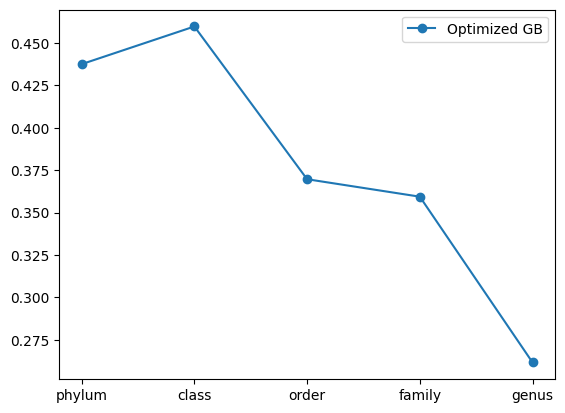

Optimized GB: [0.4260696499405167, 0.4378757239892468, 0.32305870888360666, -0.1684979679972452, 0.17599658250709524]


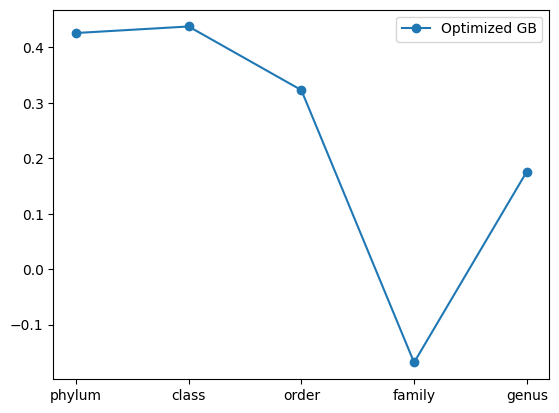

In [66]:
renamed_params = {}
for level in params:
    renamed_params[level] = {}
    for param in params[level]:
        new_param = param.split("__")[-1]
        renamed_params[level][new_param] = params[level][param]

results = {}
for level in regression.TAXONOMIC_LEVELS[1:]:
    results[level] = {}
    model =  MultiOutputRegressor(GradientBoostingRegressor(**renamed_params[level]))
    r = regression.train_evaluate_models(
        {"Optimized GB": model}, X[level], Y[level], threshold=0.003, k_fold=5
    )
    results[level]["Optimized GB"] = r["Optimized GB"]

graph_results(["Optimized GB"], results)

results = {}
for level in regression.TAXONOMIC_LEVELS[1:]:
    results[level] = {}
    model =  MultiOutputRegressor(GradientBoostingRegressor(**renamed_params[level]))
    r = regression.train_evaluate_models(
        {"Optimized GB": model}, X[level], Y[level], threshold=0.0, k_fold=5
    )
    results[level]["Optimized GB"] = r["Optimized GB"]

graph_results(["Optimized GB"], results)